## 이 노드의 루브릭

#### 1. BERT pretrained model을 활용한 KorQuAD 모델이 정상적으로 학습되었다.    
: KorQuAD 모델의 validation accuracy가 안정적으로 증가하였다.     

#### 2. KorQuAD Inference 결과가 원래의 정답과 비교하여 유사하게 나오는 것을 확인하였다.      
: 평가셋에 대해 모델 추론 결과와 실제 정답의 유사성이 확인되었다.    

#### 3. Pretrained Model 활용이 효과적임을 실험을 통해 확인하였다.         
: pretrained model을 사용하지 않았을 때 대비, 학습경과의 차이를 시각화를 통해 확인하였다.

## 목차

### 1. 데이터 로드 및 데이터 전처리            

### 2. Not-pretrained 학습 결과 확인하기

### 3. Pretrained model 로딩하기     

### 4. pretrained model finetune 하기      

### 5. Inference 수행하기       

### 6. 학습 경과 시각화 비교분석

---

## 1. 데이터 로드 및 데이터 전처리

In [2]:
#필요한 라이브러리 임포트
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re

import numpy as np
import pandas as pd

import pickle  
import random

import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
#랜덤 시드 배정
random.seed(random_seed)

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

print('임포트 완료')

임포트 완료


- 오류가 생겨서 pip freeze로 버전을 확인하였다.                     
- tensorflow와 tensorflow -addons의 버전은 각각 2.2.0, 0.12.1          
- pip install tensorflow-addons==0.11.2로 다운그레이드                
- [이 곳에서 tensorflow와 tensorflow-addons의 버전을 참고](https://stackoverflow.com/questions/65464463/importerror-cannot-import-name-keras-tensor-from-tensorflow-python-keras-eng)              

### 데이터 로드 및 내용 확인

In [10]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')
            
print('json data 프린트 함수 세팅')

json data 프린트 함수 세팅


In [4]:
#데이터 패스 입력
data_dir = os.getenv('HOME') + '/SUBMIT_MISSION_GIT/ex19_BERT/Data'
model_dir =  os.getenv('HOME') + '/SUBMIT_MISSION_GIT/ex19_BERT/Model'

In [11]:
#훈련 데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'

with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [12]:
#검증 데이터 확인
vali_json_path = data_dir + '/KorQuAD_v1.0_dev.json'

with open(vali_json_path) as f:
    vali_json = json.load(f)
    print_json_tree(vali_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


In [13]:
#Json의 실제 데이터를 json.dumps()로 확인해보기!

print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))

{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "교향곡",
              "answer_start": 54
            }
          ],
          "id": "6566495-0-0",
          "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"
        },
        {
          "answers": [
            {
              "text": "1악장",
              "answer_start": 421
            }
          ],
          "id": "6566495-0-1",
          "question": "바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?"
        },
        {
          "answers": [
            {
              "text": "베토벤의 교향곡 9번",
              "answer_start": 194
            }
          ],
          "id": "6566495-0-2",
          "question": "바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?"
        },
        {
          "answers": [
            {
              "text": "파우스트",
              "answer_start": 15
            }
          ],
          "id": "6566518-0-0",
          "question": "1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?"
        },
        {
    

# 데이터 전처리        

## 1. 띄어쓰기 단위 정보 관리

In [14]:
def is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [33]:
#공백을 기준으로 토큰화를 수행하는 함수 정의

def _tokenize_whitespace(string):
    word_tokens=[]
    char_to_word=[]
    prev_is_whitespace=True
    
    for c in string:
        if is_whitespace(c):
            prev_is_whitespace = True
            
        else:
            #이전이 공백이라면 새로운 워드 토큰으로 분류
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
            #이전이 공백이 아니라면 같은 워드 토큰으로 분류
                word_tokens[-1] += c
                
            #분류를 끝내고 이전공백=False
            prev_is_whitespace = False
            
        #전체 char_to_word에 append
        char_to_word.append(len(word_tokens)-1)
        
    return word_tokens, char_to_word

## 2. 형태소 단위 토큰화

- 한국어의 경우, 동사의 활용형이 지나치게 많기 때문에 같은 형태소를 공유하는 다양한 어미를 모두 다른 워드벡터로 분류하면 차원 수가 엄청나게 늘어나게 된다.      
- 이를 방지하기 위해 __Subword Segmentation__ 을 활용한다.     
- SentencePiece 모델을 활용한다.

In [30]:
#Vocab 모델 로드
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [34]:
#형태소 단위 토큰화 함수 세팅
def _tokenize_vocab(vocab, context_words):
    #각 단위의 길이
    word_to_token=[]
    #형태소 단위로 분리된 단어
    context_tokens=[]
    
    for (i, word) in enumerat다e(context_words):
        word_to_token.append(len(context_tokens))
        
        #형태소 단위 토큰을 분리의
        tokens = vocab.encode_as_pieces(word)
        
        for token in tokens:
            context_tokens.append(token)
            
    return context_tokens, word_to_token

__함수세팅 검증__

In [41]:
string1 = '1839년 파우스트을 읽었다.'

In [42]:
_tokenize_whitespace(string1)

(['1839년', '파우스트을', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

## 3. Improve Span     

- KorQuAD에서 질문(Question), 지문(Context), 정답(Answer)을 찾아내 본다.

In [44]:
#json의 파일 구조를 기반으로 질문, 지문, 정답을 추출해본다.

context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) -1

In [47]:
#프린트로 검증
print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


#### 위의 1.띄어쓰기 단위 토큰화, 2.형태소 단위 토큰화를 콘텍스트에 적용해본다.

In [48]:
word_tokens, char_to_word = _tokenize_whitespace(context)

print('콘텍스트를 띄어쓰기 단위 토큰화', word_tokens[:20])

char_to_word[:20], context[:20]데이터

콘텍스트를 띄어쓰기 단위 토큰화 ['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [50]:
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)

for i in range(min(20, len(word_to_token)-1)):
    print(word_to_token[i], context_tokens[word_to_token[i] :word_to_token[i+1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


> 여기서, 정답 글자의 시작 인덱스와 끝 인덱스를 띄어쓰기 단위로 변환하면 어떻게 될까?

In [53]:
#answer_start와 answer_end로 부터 word_start와 word_end를 구한다.

word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]

print('word_start/', 'word_end/', 'answer_text/', 'w데이터ord_tokens[word_start:word_end+1]')
word_start, word_end, answer_text, word_tokens[word_start:word_end+1]

word_start/ word_end/ answer_text/ word_tokens[word_start:word_end+1]


(14, 14, '교향곡', ['교향곡을'])

> 답은 14번째에 있음을 인덱스로는 찾았으나, 띄어쓰기로 찾았을 때 '교향곡을' 로 찾게 된다.        
> __이를 수정하기 위해 word_start~word_end 까지를 형태소 단위로 찾아보자__

In [54]:
token_start = word_to_token[word_start]

if word_end < len(word_to_token)-1:
    token_end = word_to_token[word_end+1]-1
else:
    token_end = len(context_tokens)-1
    
print('token_start/', 'token_end/', 'context_tokens[token_start:token_end+1]')
token_start, token_end, context_tokens[token_start:token_end+1]

token_start/ token_end/ context_tokens[token_start:token_end+1]


(19, 20, ['▁교향곡', '을'])

> - 정답만 쏙! 빼오기 위해 __answer_text를 형태소 단위로 토큰화__ 해둔다.

In [55]:
token_answer = " ".join(vocab.encode_as_pieces(answer_text))

token_answer

'▁교향곡'

### Context에서 answer의 위치를 subword상태에서 토큰화된 상태에서 찾는 함수를 세팅

In [56]:
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    
    #char_answer를 넣고 형태소 단위로 토큰화된 걔를 얻는다!
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    
    for new_start in range(token_start, token_end+1):
        for new_end in range(token_end, new_start-1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end)+1])
            
            #답안이 이미 형태소 단위 토큰화와 일치할 때
            if text_span == token_answer:
                return (new_start, new_end)
            
    return (token_start, token_end)

## 4.데이터셋 분리 

- train 데이터셋, validation 데이터셋을 분리하고     
- improve_span 함수를 통해 최종적으로 전처리한 후      
- 파일로 저장합니다.

In [67]:
def dump_korquad(vocab, json_data, out_file):
    #우선 쓰기전용으로 파일을 데려와
    with open(out_file, "w") as f:
        
        #이름은 title 컬럼으로 붙여주고.
        for data in tqdm(json_data["data"]):
            title = data['title']
        
            #패러그래프를 가져와서, 띄어쓰기 단위로 분절
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)
                
                for qa in paragraph["qas"]:
                    
                    #만약 정답의 길이가 1이라면(더 자르고 말고 할 게 없는 상태)
                    #빠져나가도록 assert
                    assert len(qa["answers"]) == 1
                    
                    qa_id = qa["id"]
                    question = qa["question"]데이터
                    
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1
                    
                    #만약 데이터 안의 정답과, 분리한 context 안의 정답이 같다면(정리할 게 없다면)
                    #빠져나가도록 assert 처리
                    assert answer_text == context[answer_start:answer_end + 1]
                    
                    #워드 스타트 = 정답 시작점
                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]
                    
                    word_answer = " ".join(context_words[word_start:word_end +데이터 1])
                    char_answer = " ".join(answer_text.strip().split())
                    
                    #이미 char_answer이 word_answer안에 있어서 처리할 필요 없다면
                    #빠져나가도록 assert 처리
                    assert char_answer in word_answer
                    
                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)
                    
                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")
                    
print('최종 전처리 및 파일 저장 함수 세팅')

최종 전처리 및 파일 저장 함수 세팅


In [68]:
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, vali_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
#최종 전처리가 잘 되었는지 확인해보자구!
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

## 5. 데이터셋 로드

- 지금까지 만든 데이터셋을 메모리에 로드한다.

In [70]:
train_json = os.path.join(data_dir, "korquad_train.json")
vali_json = os.path.join(data_dir, "korquad_dev.json")

In [73]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [74]:
args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})

In [75]:
args

{'max_seq_length': 384, 'max_query_length': 64}

#### 생성한 데이터셋 파일을 메모리에 로딩한다.

In [77]:
#max길이와 max쿼리를 정하기 위해, 위의 config를 세팅하여 지정해주었다.
#이를 토대로 파일을 메모리에 로딩하는 함수를 정의하였다.
def load_data(args, filename):
    
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [78]:
# 학습 데이터의 인풋, 라벨을 로드한다.
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


In [79]:
# 검증 데이터의 인풋, 라벨을 로드한다.
vali_inputs, vali_labels = load_data(args, vali_json)
print(f"dev_inputs: {vali_inputs[0].shape}")
print(f"dev_inputs: {vali_inputs[1].shape}")
print(f"dev_labels: {vali_labels[0].shape}")
print(f"dev_labels: {vali_labels[1].shape}")

Loading ...: |          | 0/? [00:00<?, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


#### 데이터셋 확인!

In [80]:
# Question과 Context가 포함된 입력데이터 1번째
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [81]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [82]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]

(37, 37)

## 2. BERT 모델을 활용한 도전

## BERT 모델을 구성하는 함수 및 레이어 세팅하기

In [91]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    return tf.zeros_initializer


class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [92]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 
class SharedEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [93]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [94]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [95]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name="multi_head_attention"):
        
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [96]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [97]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### 레이어를 기반으로 한 BERT 구성

In [98]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

### BERT를 활용한 도전

- 추후 Pretrained BERT 모델과의 차이를 알기 위해, BERT 모델을 활용하여 학습시켜 본다.

In [85]:
#BERT 레이어에 Fully connected layer를 붙여, Kor용으로 finetune하기 위한 모델 클래스이다.
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) 
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [86]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [88]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
vali_dataset = tf.data.Dataset.from_tensor_slices((vali_inputs, vali_labels)).batch(bert_batch_size)

In [99]:
model = BERT4KorQuAD(config)

### 학습시키기

In [100]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [101]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [103]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, vali_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 3.5989, 4.1543, acc: 0.1487, 0.1289
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 3.6529, 4.1514, acc: 0.1559, 0.1304
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.6255, 4.1796, acc: 0.1626, 0.1413
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.7802, 4.3512, acc: 0.1677, 0.1487
save best model


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 4.1029, 4.6986, acc: 0.1508, 0.1426


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 4.1676, 5.0859, acc: 0.1503, 0.1382


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 4.5432, 5.2922, acc: 0.1533, 0.1336


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 5.0988, 5.8246, acc: 0.1397, 0.1331


|          | 0/? [00:00<?, ?it/s]

eval 8 >> loss: 5.3932, 6.2501, acc: 0.1396, 0.1282
early stopping


## 3. Pretrained model 로딩하기

In [83]:
## pretrained 모델을 로딩하여 model을 생성해본다.

In [106]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

print(checkpoint_file)loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, vali_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

model = BERT4KorQuAD(config)

#가중치 파일이 얌전히 그 위치에 있다묜
if os.path.exists(checkpoint_file):
    #pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4,10))
    segments = np.random.randint(0, 2, (4,10))
    model(enc_tokens, segments)
    
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)
    
    model.summary()
        
else:
    print("There is not pretrained-Model")

/home/ssac23/SUBMIT_MISSION_GIT/ex19_BERT/Model/bert_pretrain_32000.hdf5
Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_75 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


#### Pre-trained된 모델로 학습을 진행해본다.

In [107]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, vali_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

|          | 0/? [00:00<?, ?it/s]

eval 0 >> loss: 4.0427, 4.6293, acc: 0.0751, 0.0544
save best model


|          | 0/? [00:00<?, ?it/s]

eval 1 >> loss: 4.0678, 4.6048, acc: 0.0804, 0.0630
save best model


|          | 0/? [00:00<?, ?it/s]

eval 2 >> loss: 3.8685, 4.3868, acc: 0.1222, 0.1002
save best model


|          | 0/? [00:00<?, ?it/s]

eval 3 >> loss: 3.7744, 4.3439, acc: 0.1378, 0.1283
save best model


|          | 0/? [00:00<?, ?it/s]

eval 4 >> loss: 3.8352, 4.2843, acc: 0.1506, 0.1327
save best model


|          | 0/? [00:00<?, ?it/s]

eval 5 >> loss: 3.8439, 4.4189, acc: 0.1496, 0.1378
save best model


|          | 0/? [00:00<?, ?it/s]

eval 6 >> loss: 4.1823, 4.8241, acc: 0.1375, 0.1366


|          | 0/? [00:00<?, ?it/s]

eval 7 >> loss: 4.5500, 5.0323, acc: 0.1297, 0.1269


|          | 0/? [00:00<?, ?it/s]

eval 8 >> loss: 4.8428, 5.6985, acc: 0.1331, 0.1292


|          | 0/? [00:00<?, ?it/s]

eval 9 >> loss: 5.1873, 6.1955, acc: 0.1239, 0.1229


|          | 0/? [00:00<?, ?it/s]

eval 10 >> loss: 5.4551, 6.5254, acc: 0.1194, 0.1225
early stopping


## 5. Inference 수행하기

- pretrained 데이터를 활용하여 모델을 학습시켰고, 실제로 퀴즈 풀이 결과를 확인하여 학습 결과를 체크해 보자.

In [108]:
def do_predict(model, question, context):
   
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [112]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    
    #총 정답 수를 확인하기 위해 변수를 적용하였다.
    count = 100
    
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
            
            if answer != answer_predict:
                count -= 1
            
        if 100 < i:
            print("맞은 정답 개수 : ", count)
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12

70
질문 :  2012년 중국 BTV에서 노아의 방주가 발견되었다고 보도한 나라는?
지문 :  일반적으로 터키의 아라랏 산의 경우, 실제 성경 속에 등장하는 아라랏 산은 지금 아라랏이라 불리는 하나의 산이 아니라 당시 아라랏이라고 불리던 광대한 지역의 산들을 모두 가리키는 표현이라는 주장도 나와 있으며, 또한 목재로 만들어진 방주가 현재까지 남아있을 수는 없다는 비판도 받고 있다. 예를 들어, 1955년 프랑스의 탐험가인 Fernand Navarra가 발견한 목재 파편의 경우, 스페인의 임업 연구소에서 목재의 특성을 토대로 5000년 전의 것이라고 밝히긴 했으나 그 신빙성에 문제점이 있었고 후에 방사성 동위원소 측정법 등의 첨단 과학의 도움을 받은 5개 연구소에서 모두 기원 이후의 시기로 연대를 측정했다. 2009년 뿐 아니라 거의 수년에 한번씩 어디선가 노아의 방주를 발견했다는 주장들이 제시되었지만, 심지어 같은 창조과학을 주장하는 사람들에게조차 비판받을 정도였다. 노아의 방주가 다른 여러 지방에서 발견되었다는 주장이 있으나 너무나 다양한 지방(중국, 터키, 인도 등)에 걸쳐있고, 그 주장도 각각 제각각이므로 신빙성이 없다. 예를 들자면, 중국 BTV에서는 2012년에 중국에서 노아의 방주가 발견되었다는 보도를 하였는데, 이것은 창조과학회에서 주장하는 장소와는 전혀 다른곳이기도 하며, 화석화가 진행되지 않은 나무의 존재등으로 가짜임이 밝혀졌다. 때때로 일부 "학자"라 칭하는 사람들이 이를 찾기 위해 노력한다고 주장하지만, 이는 학계에서 유사지질학으로 평가되고 있다.
정답 :  중국
예측 :  터키의 아라랏 산의 경우, 실제 성경 속에 등장하는 아라랏 산은 지금 아라랏이라 불리는 하나의 산이 아니라 당시 아라랏이라고 불리던 광대한 지역의 산들을 모두 가리키는 표현이라는 주장도 나와 있으며, 또한 목재로 만들어진 방주가 현재까지 남아있을 수는 없다는 비판도 받고 있다. 예를 들어, 1955년 프랑스의 탐험가인 Fernand Navarra가 발견한 목재 파편의 

> - 학습된 모델에게 100개의 질문을 하고, 실제 정답과 예측 정답을 비교해 보았다.     
> - 변수를 통해 확인한 결과, __총 100개의 질문 중 맞은 정답 개수는 86개이다.__       
> - 단, 이는 단순히 정답 != 정답 예측 일 경우만 센 것으로, 예측이 정답보다 포괄적인 경우(ex)정답이 1869년이고, 예측이 1869년 메이지 2년인 경우 1869년==메이지 2년이므로 넓은 범위의 정답으로 볼 수 있겠다.) 를 제외한 것이므로, 실질적인 정답률은 이보다 높을 수 있겠다.

## 6. 시각화하여 확인해보기

> - 히스토리 저장 안하고 돌려서 다시 돌리는 중 ㅠㅠ

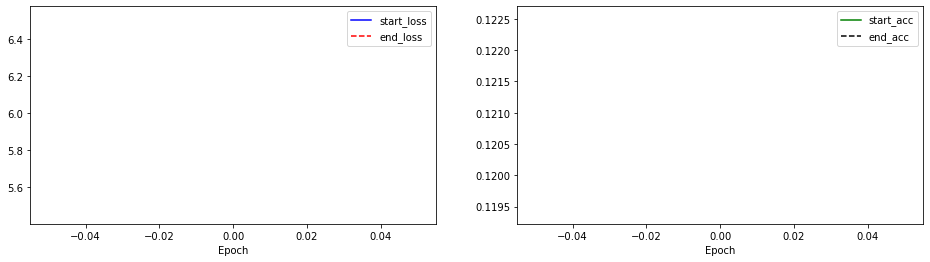

In [115]:
start_loss, end_loss, start_acc, end_acc
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(start_loss, 'b-', label='start_loss')
plt.plot(end_loss, 'r--', label='end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(start_acc, 'g-', label='start_acc')
plt.plot(end_acc, 'k--', label='end_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()